In [1]:
from pathlib import Path

import tensorflow as tf
import cv2
import csv
import matplotlib.pyplot as plt
import numpy as np

from src.misc.generator import IMaterialistGenerator
from src.misc.utils import create_model_architecture
from src.models import unet
from src.misc.colors import COLORS
from src.misc.dataset_resizer import dataset_resizer

### Dataset information

In [2]:
N_CLASSES = 46
N_CLASSES_WITH_BACKGROUND = N_CLASSES + 1
N_ATTRIBUTES = 341
N_ATTRIBUTES_WITH_BACKGROUND = N_ATTRIBUTES + 1
IS_ATTRIBUTE = False
N_TARGETS = N_ATTRIBUTES_WITH_BACKGROUND if IS_ATTRIBUTE else N_CLASSES_WITH_BACKGROUND

### Model parameters

In [3]:
BATCH_SIZE = 2
SIZE = 512
LR = 1e-3
DROPOUT_RATE = 0.0
MODEL_NAME = "My_BRAND_NEW.h5"
SERIF = False

In [5]:
model = unet.main(SIZE, n_targets=N_TARGETS, lr=LR, dropout_rate=DROPOUT_RATE, is_attribute=IS_ATTRIBUTE, serif=SERIF)
#model = tf.keras.models.load_model(Path("saved_models", "MODEL2_class.h5"))

### Extract N images from the whole dataset (to facilitate testing)

In [6]:
#dataset_resizer(2, Path(Path.home(), "Downloads", "Jdownload", "IMaterialist-fashion-2020"))

### Create image generator and fit model with it

In [7]:
generator = IMaterialistGenerator(Path("train.csv"), is_attribute=IS_ATTRIBUTE)

In [9]:
#model.fit(generator(N_TARGETS, SIZE, BATCH_SIZE, serif=SERIF), epochs=15, steps_per_epoch=20)
model = tf.keras.models.load_model(Path("saved_models", "MODEL2_class.h5"))

### Helpers

In [11]:
def show(img: np.ndarray) -> None:
    plt.imshow(img, interpolation='none')
    plt.show()

In [12]:
def predict(model, img: np.ndarray) -> np.ndarray:
    predictions = model.predict(np.expand_dims(img, 0))
    labels = np.argmax(predictions.squeeze(), -1)
    return COLORS[labels].astype(np.uint8)

In [13]:
def overlap(img: np.ndarray, labels: np.ndarray) -> np.ndarray:
    img = cv2.resize(img, (SIZE, SIZE)).astype(np.float64)
    assert img.shape == labels.shape, f"img.shape => {img.shape} != {labels.shape} <= labels.shape"
    return ((labels.astype(np.float64) + img) / 2).astype(np.uint8)

In [14]:
def test_image(model, image_path: Path) -> None:
    img = cv2.resize(plt.imread(image_path), (SIZE, SIZE))
    labels = predict(model, img)
    plt.rcParams["figure.figsize"] = (20,3)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    ax1.imshow(img)
    ax2.imshow(labels)
    ax3.imshow(overlap(img, labels))
    ax4.imshow(ground_truth(image_path))
    fig.show()

In [15]:
def test_train_csv_images(model) -> None:
    for image_path in Path("dataset").iterdir():
        test_image(model, image_path)

In [16]:
def ground_truth(image_path: Path) -> np.ndarray:
    image_id = image_path.name[:-len(".jpg")]
    labels = {}
    h, w = None, None
    with open("train.csv") as csv_file:
        reader = csv.DictReader(csv_file)
        for line_dict in reader:
            if line_dict["ImageId"] == image_id:
                h, w = int(line_dict["Height"]), int(line_dict["Width"])
                if int(line_dict["ClassId"]) not in labels:
                    labels[int(line_dict["ClassId"])] = line_dict["EncodedPixels"]
                else:
                    labels[int(line_dict["ClassId"])] += f" {line_dict['EncodedPixels']}"
    
    seg_labels = np.zeros((h, w, 3), dtype=np.uint8)  
    for label_id, encoded_pixels in labels.items():
        encoded_pixels = encoded_pixels.split()
        for i in range(0, len(encoded_pixels), 2):
            index, occurrences = int(encoded_pixels[i]), int(encoded_pixels[i + 1])
            pixel_w, pixel_h = divmod(index, h)
            seg_labels[pixel_h:pixel_h + occurrences, pixel_w] = COLORS[label_id]
    
    return cv2.resize(seg_labels, (SIZE, SIZE))

AssertionError: img.shape => (512, 512, 3) != (1024, 1024, 3) <= labels.shape

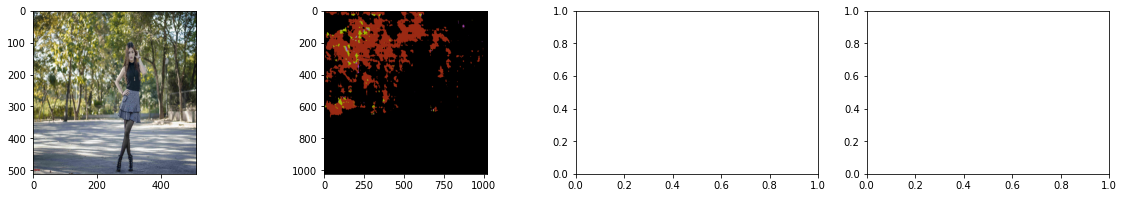

In [17]:
test_train_csv_images(model)